# Explore

In [ ]:
from GRALE.main import GRALE_model
from GRALE.data.dataset import DataModule

checkpoint_path = "checkpoints/coloring_big_base_2/last.ckpt"

model = GRALE_model.load_from_checkpoint(checkpoint_path)
model = model.to('cuda')
model = model.eval()

datamodule = DataModule(
        path_h5="data/h5/COLORING_big.h5",
        batch_size=16,
        n_workers=8
        )
loader = datamodule.val_dataloader()

{'n_layers': 7, 'n_heads': 8, 'norm_post_or_pre': 'pre', 'triangular_attention_mode': 'none', 'triangular_multiplication_mode': 'row', 'node_hidden_dim': 256, 'node_model_dim': 128, 'node_labels_dim': 4, 'node_features_dim': 4, 'edge_hidden_dim': 128, 'edge_model_dim': 128, 'edge_labels_dim': 2, 'edge_features_dim': 1, 'n_nodes_max': 32, 'graph_embedding_dim': 128, 'dropout_attn': 0.0, 'dropout_mlp': 0.0, 'dropout_skip': 0.0}
---
Loading the full train dataset of in memory. If this causes out of memory issues, consider setting n_data_epoch.
Train dataset size: 600000
---
Loading the full valid dataset in memory. If this causes out of memory issues, consider setting n_data_valid.
Valid dataset size: 10000
---


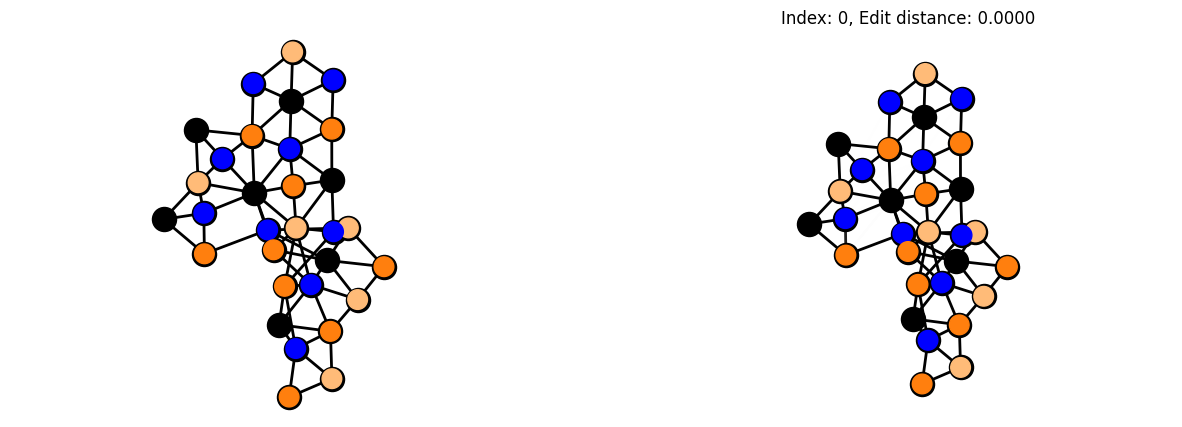

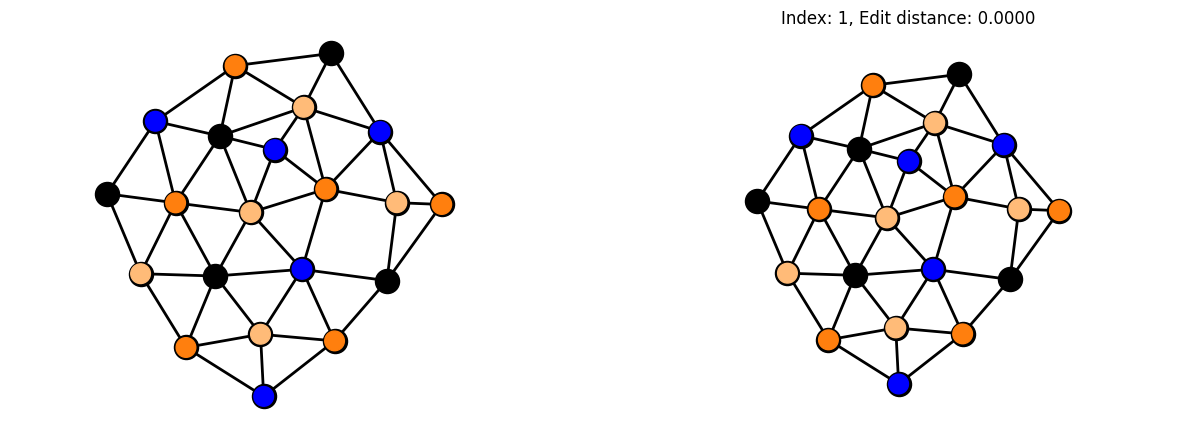

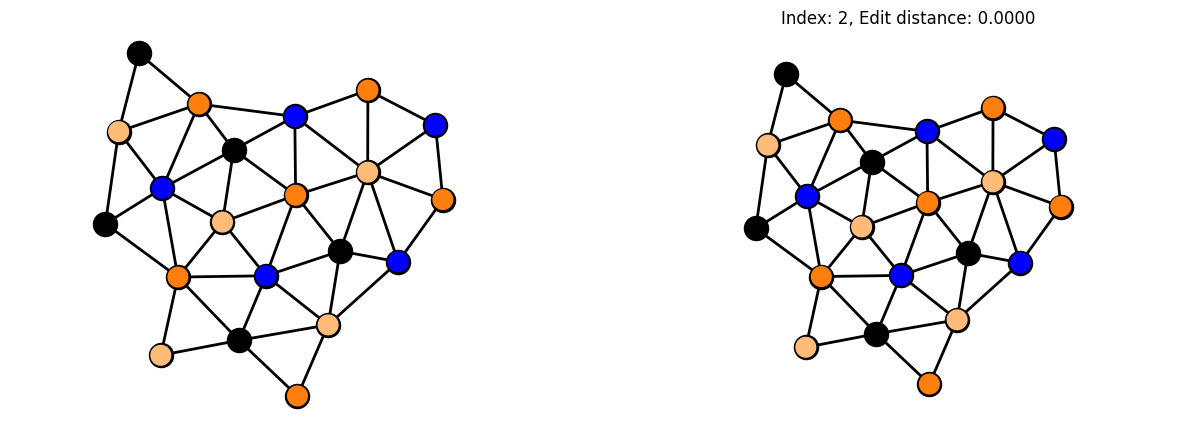

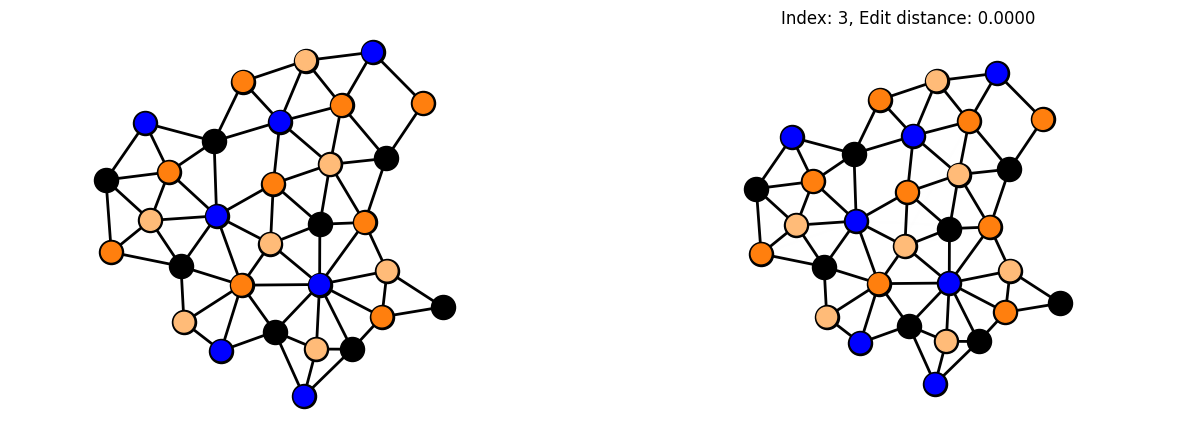

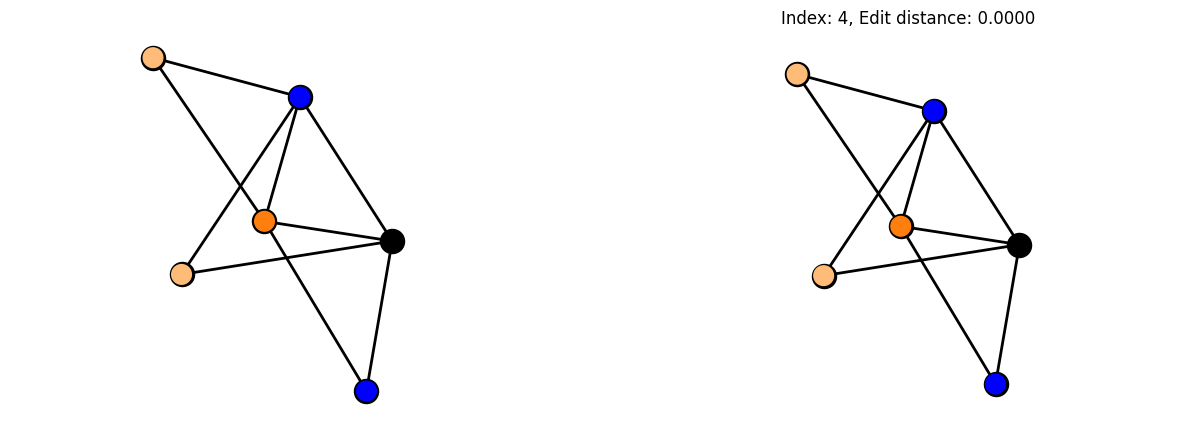

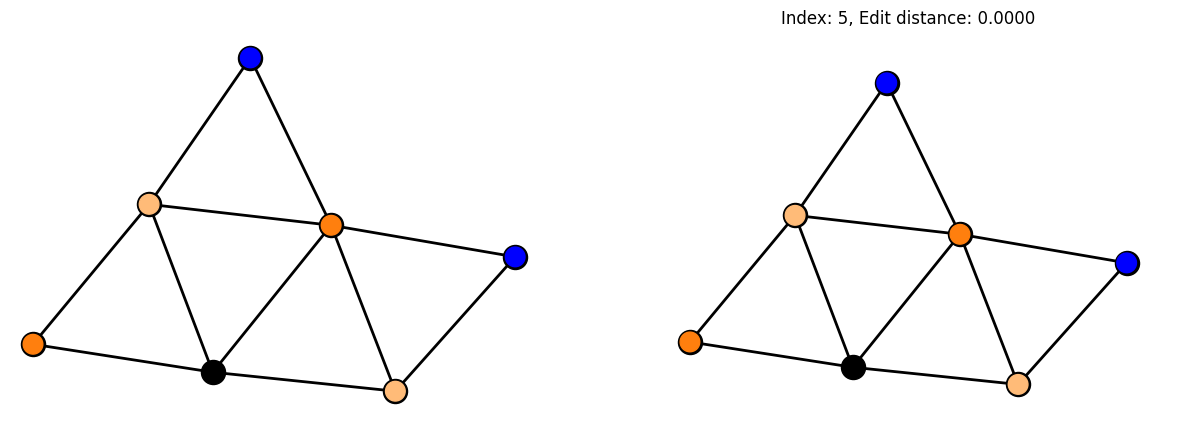

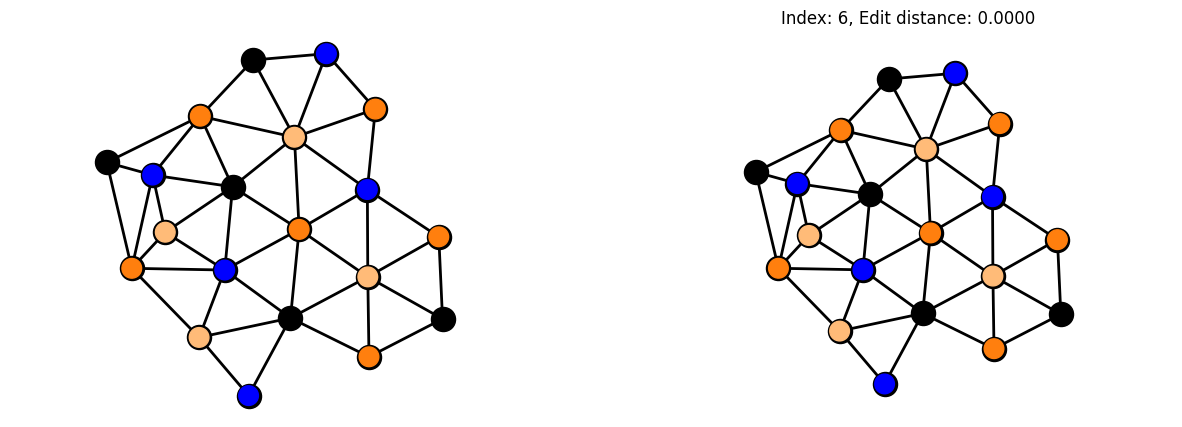

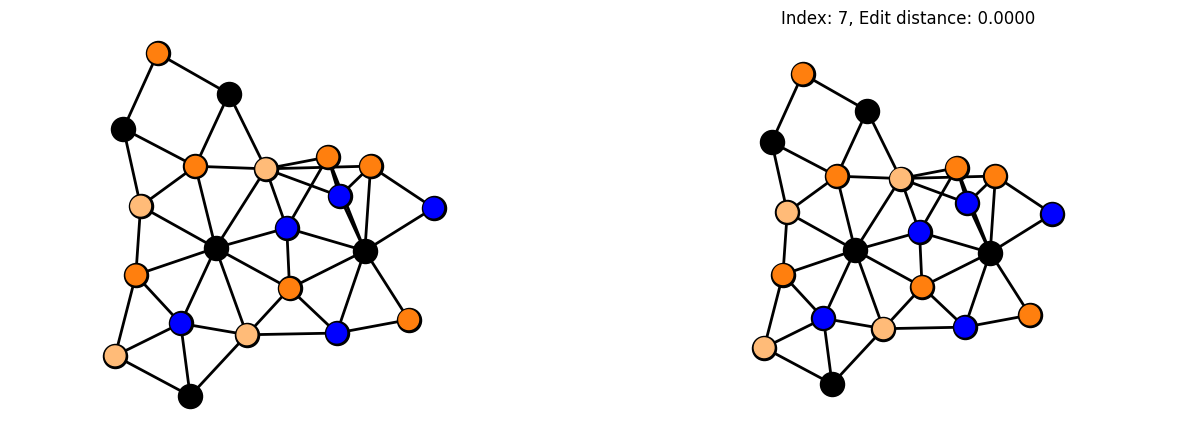

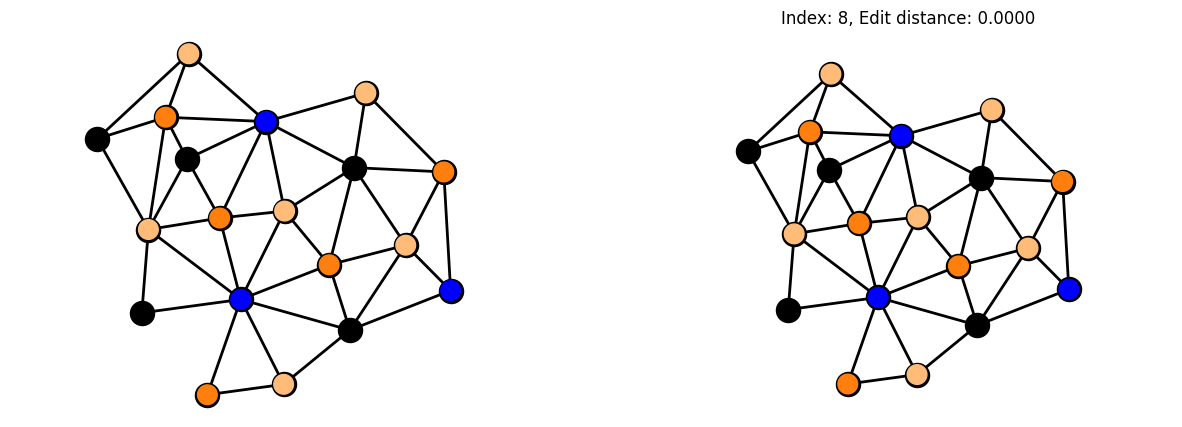

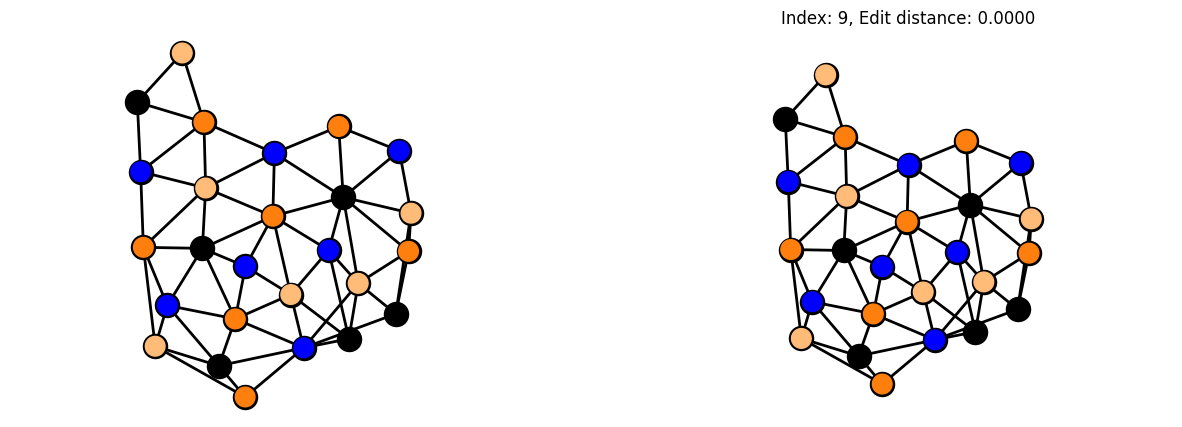

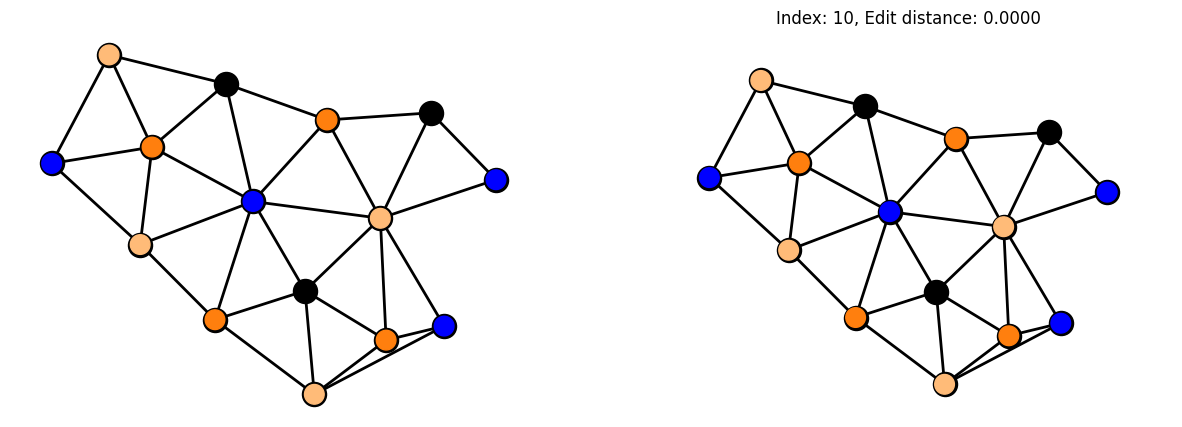

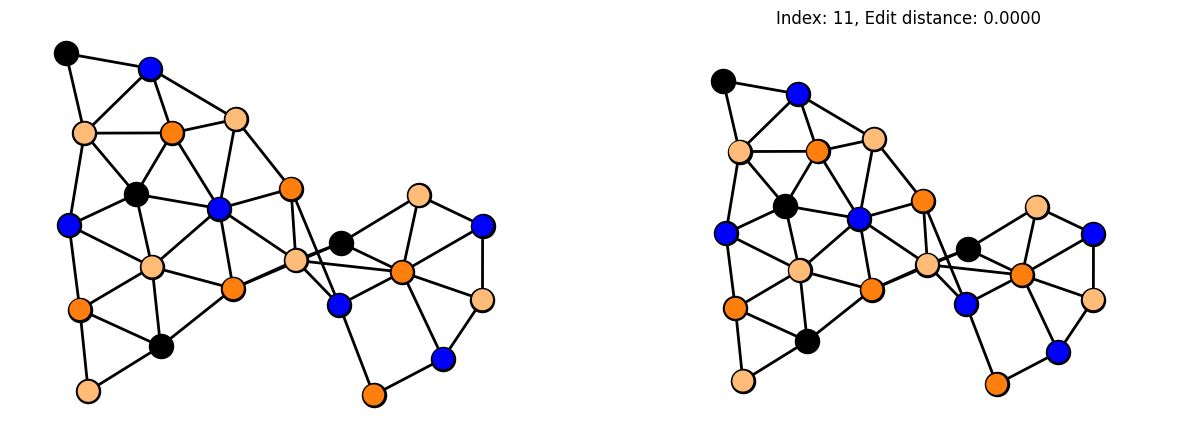

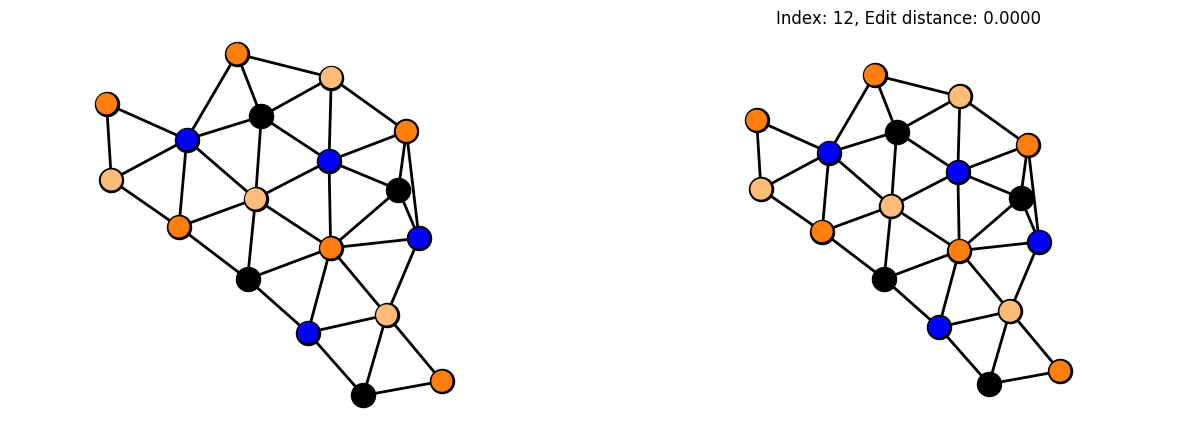

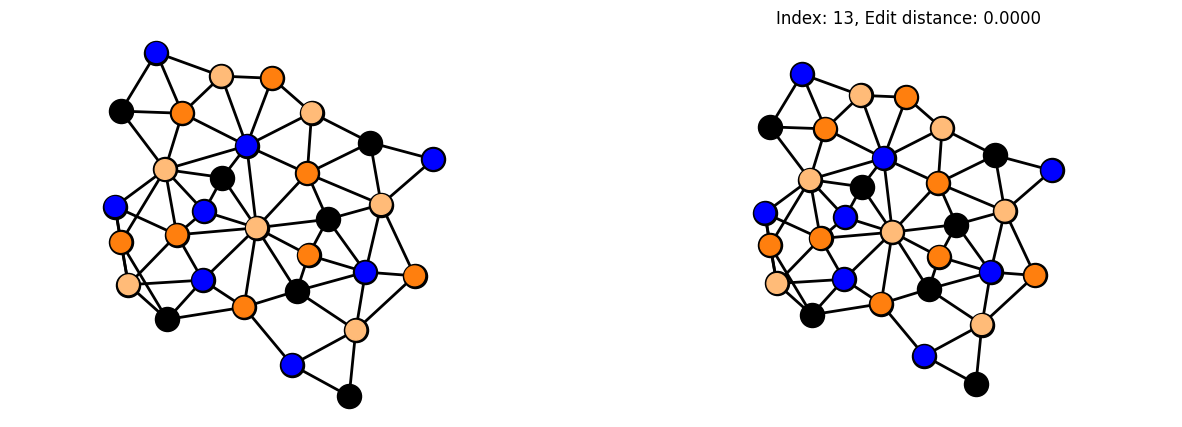

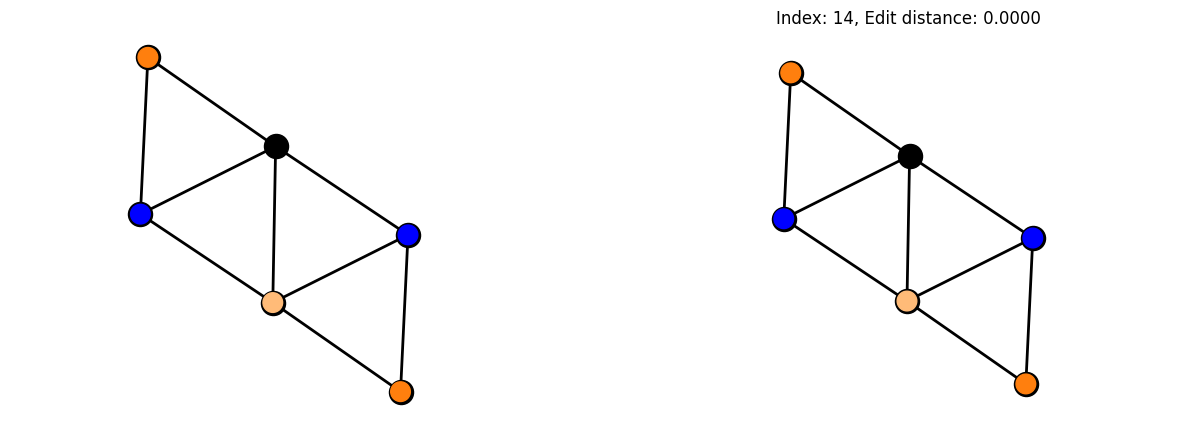

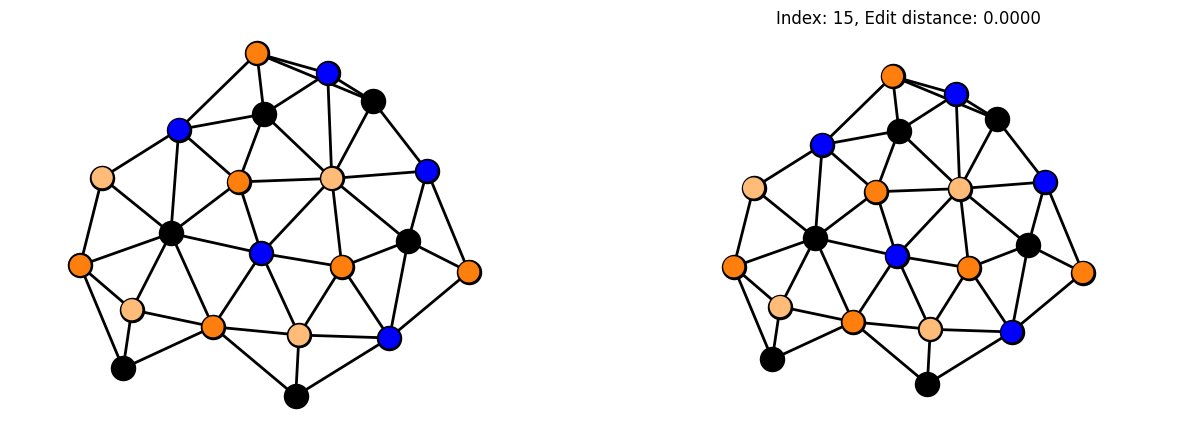

In [2]:
import matplotlib.pyplot as plt
from GRALE.vizualization.plots import plot_graph

min_size = 5
node_size = 200
frame = False
edge_weight = True
hard_permuter = True

for inputs in loader:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        if size < min_size:
            continue
        node_labels_inputs = inputs.nodes.labels[k][:size:]
        node_labels_preds = outputs.nodes.labels[k][:size,:]
        A_inputs = inputs.edges.adjacency[k][:size,:size]
        A_preds = outputs.edges.adjacency[k][:size,:size]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        pos = 'kamada'
        pos = plot_graph(node_labels_inputs,A_inputs,ax=ax1,pos=pos,frame=frame,edge_weight=edge_weight)
        plot_graph(node_labels_preds,A_preds,ax=ax2,pos=pos,frame=frame,edge_weight=edge_weight)
        plt.title(f'Index: {k}, Edit distance: {edit[k]:.4f}')
        plt.show()
        
    break

In [71]:
permutation_matrices = model.canonical_permutation(inputs,hard_matcher=True)
for k in range(10):
    h = inputs.h[k]
    size = int(h.sum(dim=-1))
    list_values = permutation_matrices[k][:size]
    set_values = set(list_values.tolist())
    print(set_values)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [38]:
import torch

index1 = 5
index2 = 3
n_values = 16

embeddings_all = model.encode(inputs)
embeddings1 = embeddings_all[index1]
embeddings2 = embeddings_all[index2]

alphas = torch.linspace(0,1,n_values).to(embeddings1.device)
embeddings = alphas[:, None, None] * embeddings1[None, :, :] + (1 - alphas[:, None, None]) * embeddings2[None, :, :] 
outputs = model.decode(embeddings, logits=False)

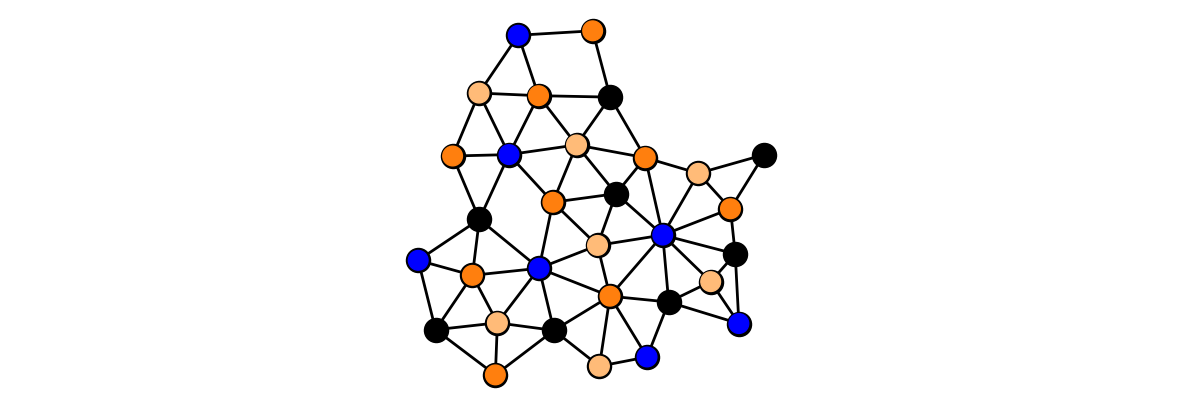

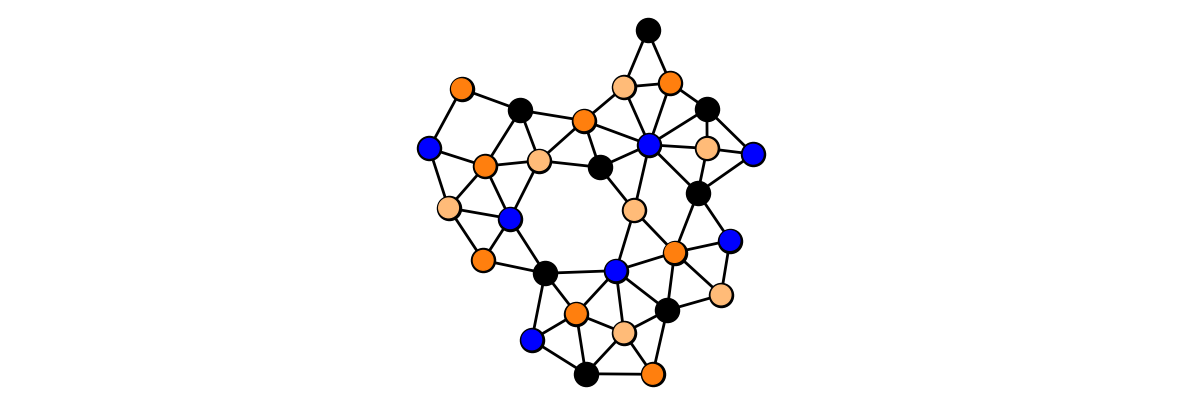

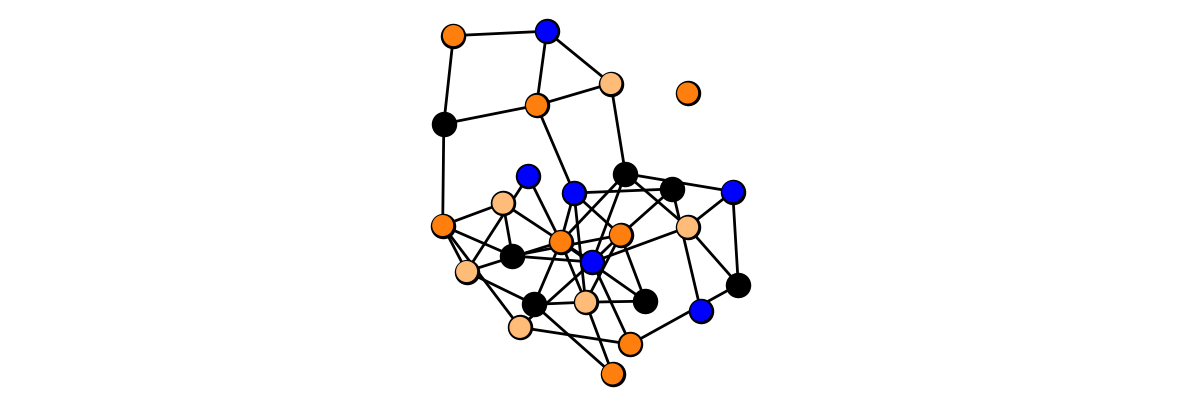

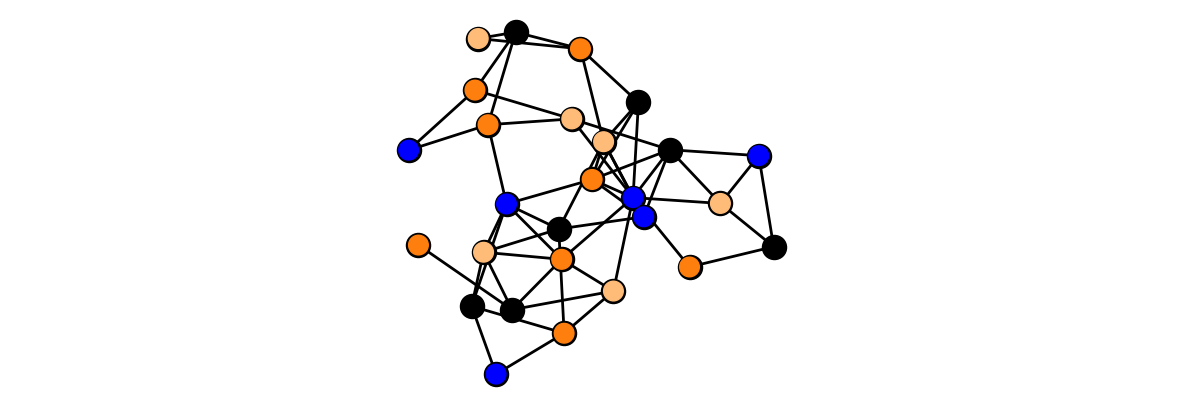

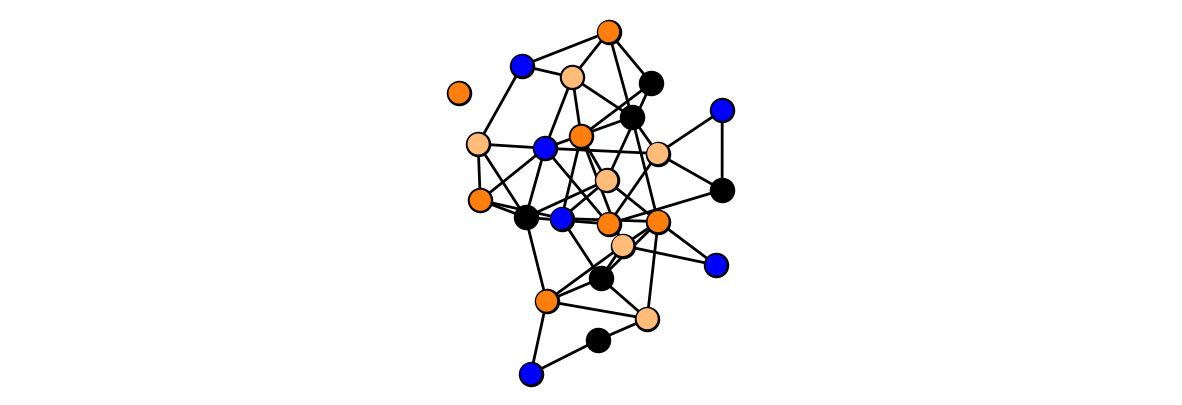

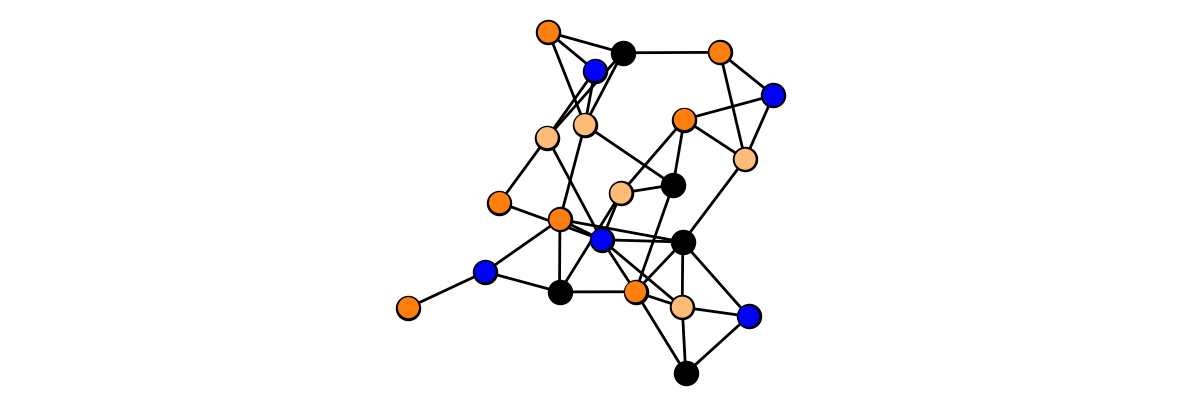

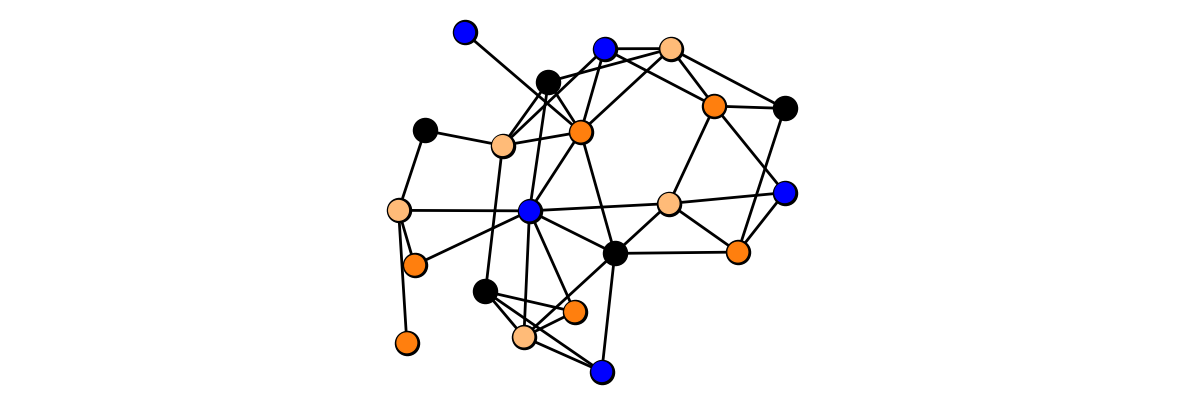

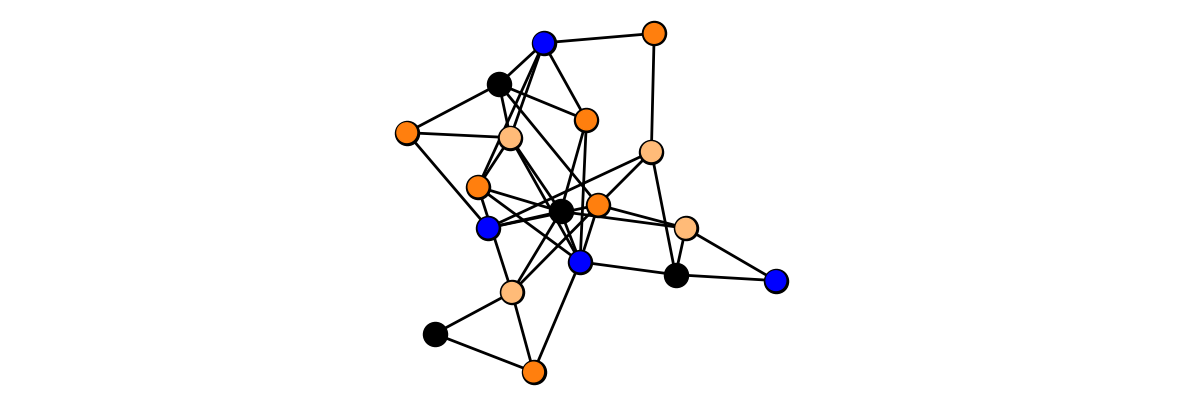

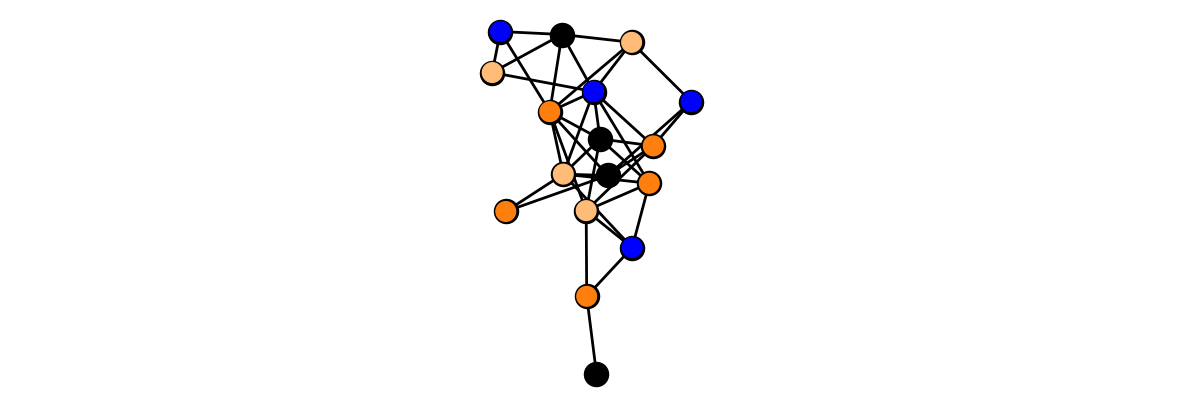

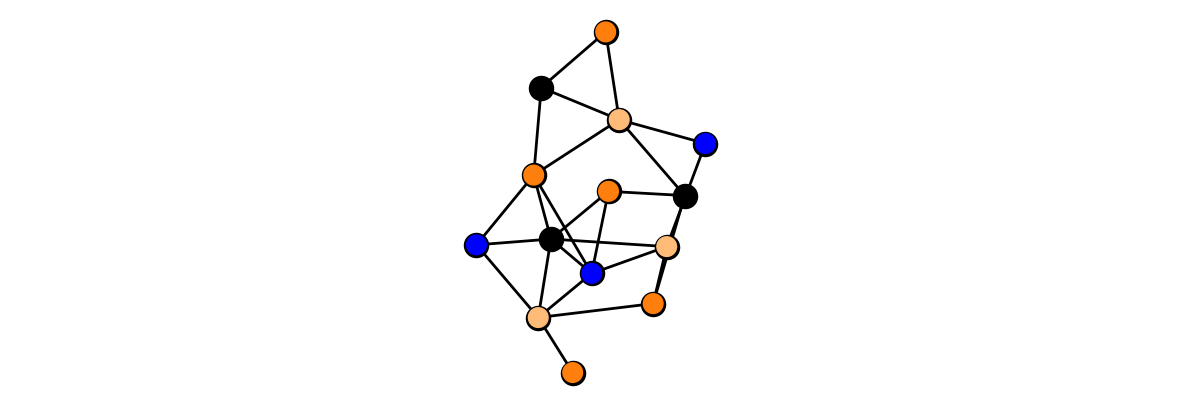

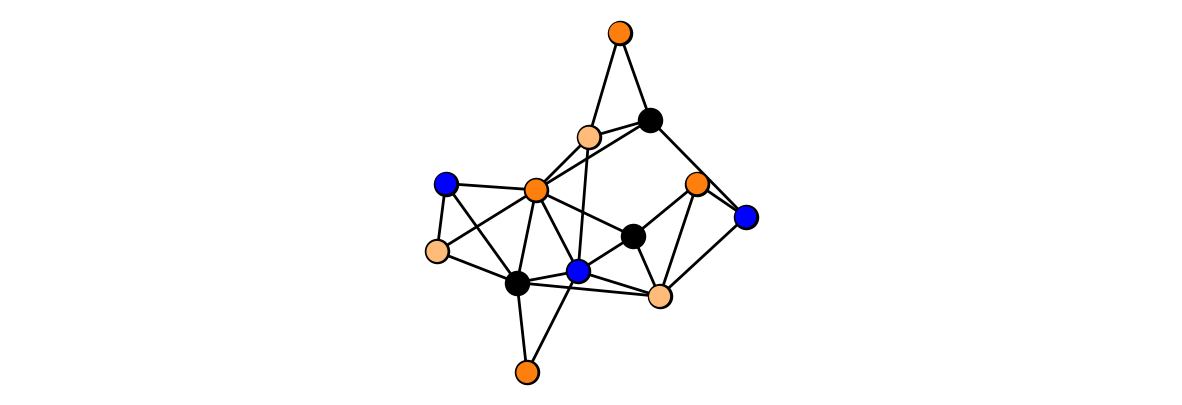

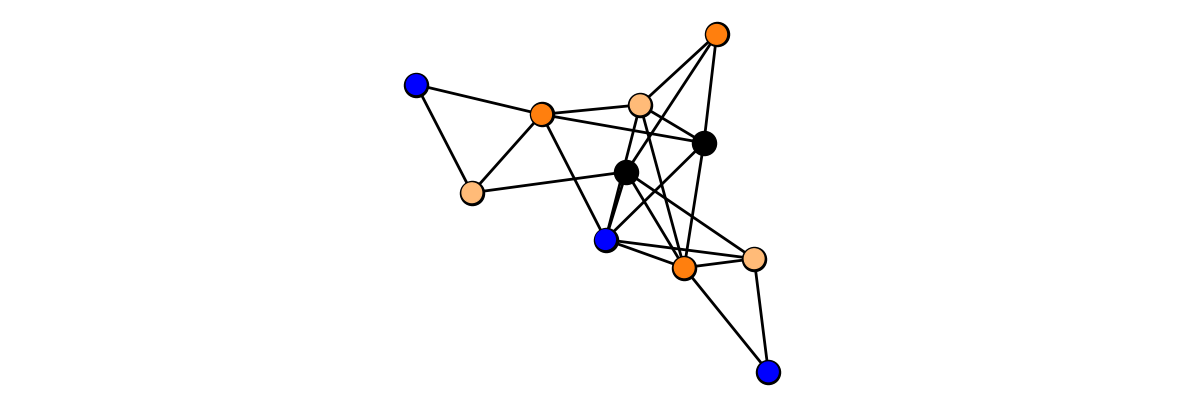

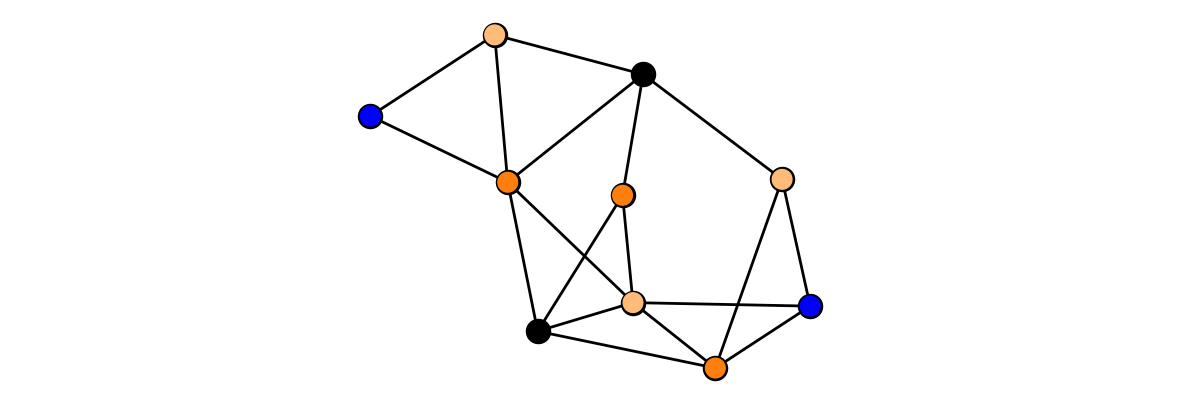

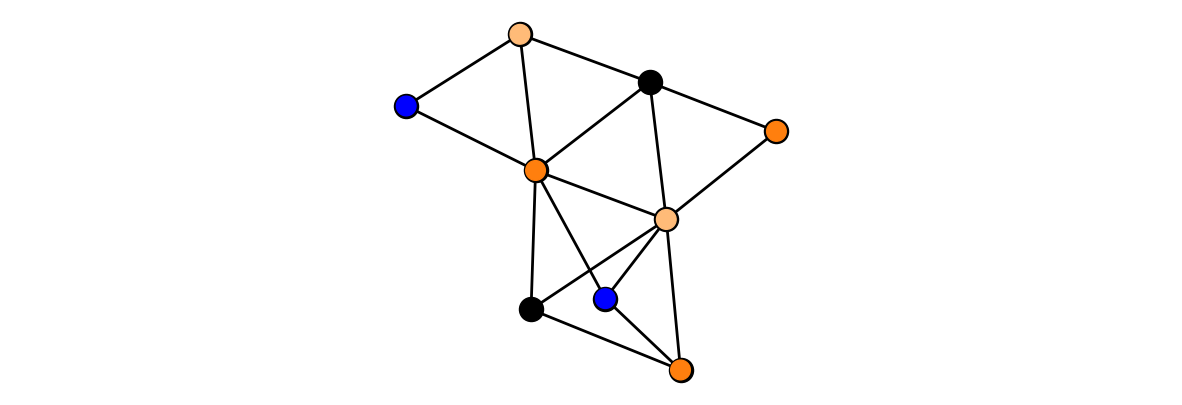

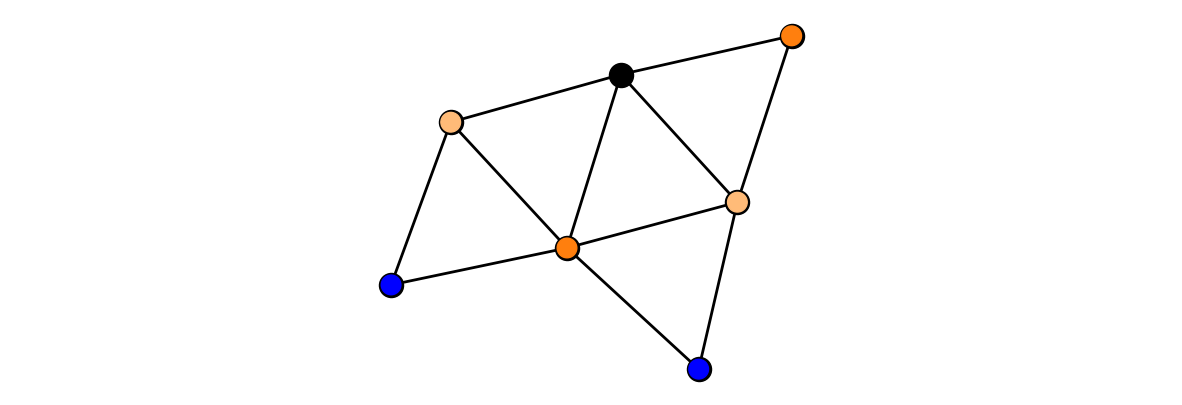

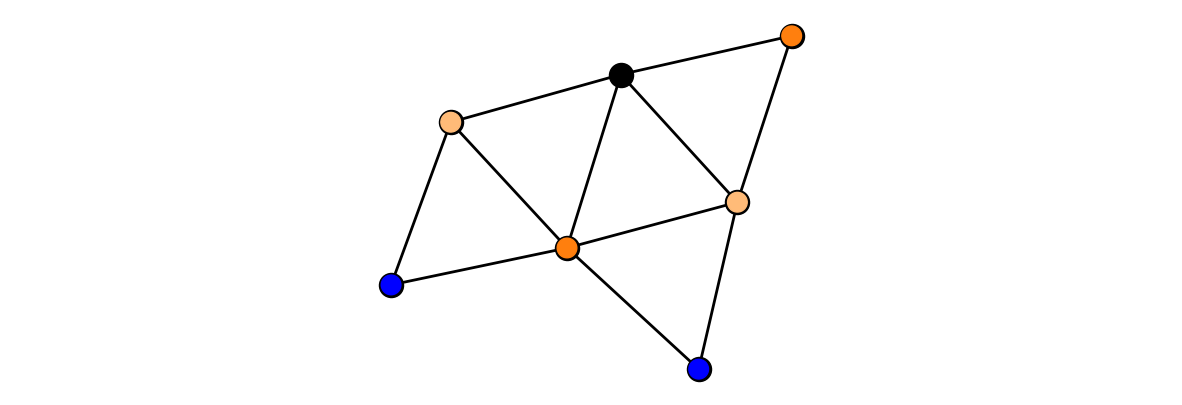

In [ ]:
torch.set_printoptions(sci_mode=False, precision=2)

epsilon = 1e-4

pos = 'kamada'
for output in outputs: 
    h = output.h
    h = (h > 0.5)
    node_labels = output.nodes.labels[h, :]
    A = output.edges.adjacency[h,:][:,h]
    A = torch.where(A > epsilon, A, torch.zeros_like(A))
    A = torch.where(A > 1 - epsilon, torch.ones_like(A), A)
    fig, ax = plt.subplots(figsize=(15,5))
    pos = plot_graph(node_labels,A,ax=ax,pos=pos,frame=frame,edge_weight=False)
    plt.show()


In [7]:
epsilon = 1e-2
A = outputs.edges.adjacency
A = torch.where(A < epsilon, torch.zeros_like(A), A)
torch.count_nonzero(A*(1-A)) / (A.shape[0] * A.shape[1] * A.shape[2])

tensor(0.74, device='cuda:0')

# Generate dataset

Choose the index of the graphs to interpolate between

In [8]:
index1 = 3
index2 = 5

Compute the embeddings

In [11]:
from GRALE.main import GRALE_model
from GRALE.data.dataset import DataModule

checkpoint_path = "checkpoints/coloring_big_base_2/last.ckpt"

model = GRALE_model.load_from_checkpoint(checkpoint_path)
model = model.to('cuda')
model = model.eval()

datamodule = DataModule(
        path_h5="data/h5/COLORING_big.h5",
        batch_size=16,
        n_workers=8
        )
loader = datamodule.val_dataloader()

inputs = next(iter(loader))
inputs = inputs.to('cuda')

print(f'Size index {index1}')
print(inputs.h[index1].sum())
print(f'Size index {index2}')
print(inputs.h[index2].sum())

embeddings_all = model.encode(inputs)
embeddings1 = embeddings_all[index1]
embeddings2 = embeddings_all[index2]


{'n_layers': 7, 'n_heads': 8, 'norm_post_or_pre': 'pre', 'triangular_attention_mode': 'none', 'triangular_multiplication_mode': 'row', 'node_hidden_dim': 256, 'node_model_dim': 128, 'node_labels_dim': 4, 'node_features_dim': 4, 'edge_hidden_dim': 128, 'edge_model_dim': 128, 'edge_labels_dim': 2, 'edge_features_dim': 1, 'n_nodes_max': 32, 'graph_embedding_dim': 128, 'dropout_attn': 0.0, 'dropout_mlp': 0.0, 'dropout_skip': 0.0}
---
Loading the full train dataset of in memory. If this causes out of memory issues, consider setting n_data_epoch.
Train dataset size: 600000
---
Loading the full valid dataset in memory. If this causes out of memory issues, consider setting n_data_valid.
Valid dataset size: 10000
---
Size index 3
tensor(31, device='cuda:0')
Size index 5
tensor(7, device='cuda:0')


Define the distribution of interpolation coefficients

In [32]:
import numpy as np
def sample_alpha(n_samples):
    #return np.random.uniform(0,1,size=(n_samples,))
    return np.random.beta(0.5, 0.5, size=(n_samples,))

Generatate h5

In [33]:
import tqdm
import torch
import numpy as np
import h5py
import os

train_samples = 1000
valid_samples = 1000
test_samples = 1000
batchsize = 16 # Reduce if out of memory

path_h5 = f'data/h5/interpolation_{index1}_{index2}.h5'

if os.path.exists(path_h5):
    os.remove(path_h5)

def check_sparsity_A(A):
    print("Sparsity A:", 1 - (np.count_nonzero(A) / (A.shape[0] * A.shape[1]* A.shape[2])))

def sparsify_A(A, threshold=1e-4):
    A = np.where(A < threshold, np.zeros_like(A), A)
    return A

for split, split_samples in zip(['train','valid','test'], [train_samples, valid_samples, test_samples]):
    
    X = []
    A = []
    node_mask = []
    alpha = []

    n_samples = 0
    
    while n_samples < split_samples:
        
        alpha_batch = sample_alpha(batchsize)
        alpha_batch = torch.tensor(alpha_batch, dtype=torch.float32).to(embeddings1.device)
        embeddings = alpha_batch[:, None, None] * embeddings1[None, :, :] + (1 - alpha_batch[:, None, None]) * embeddings2[None, :, :] 
        with torch.no_grad():
            outputs = model.decode(embeddings, logits=False)

        X.append(outputs.nodes.labels.cpu().numpy())
        A.append(outputs.edges.adjacency.cpu().numpy())
        node_mask.append((outputs.h.cpu().numpy() > 0.5).astype(np.bool_))
        alpha.append(alpha_batch.cpu().numpy())
        n_samples += batchsize
        
    X = np.vstack(X)[:split_samples,:,:]
    A = np.vstack(A)[:split_samples,:,:]
    node_mask = np.vstack(node_mask)[:split_samples,:]
    alpha = np.hstack(alpha)[:split_samples]
    print(f'Split: {split}')
    check_sparsity_A(A)
    print(f'If you want sparse A consider calling sparsify_A function')
    #A = sparsify_A(A, threshold=1e-4)
    
    with h5py.File(path_h5, 'a') as f:
        grp = f.require_group(split)
        grp.create_dataset('X', data=X)
        grp.create_dataset('A', data=A)
        grp.create_dataset('node_mask', data=node_mask)
        grp.create_dataset('alpha', data=alpha)
    


Split: train
Sparsity A: 0.0
If you want sparse A consider calling sparsify_A function
Split: valid
Sparsity A: 0.0
If you want sparse A consider calling sparsify_A function
Split: test
Sparsity A: 0.0
If you want sparse A consider calling sparsify_A function


Check that the dataset has been created properly

In [34]:
print(path_h5)
dataset = h5py.File(path_h5, 'r')['train']
print(dataset['X'].shape)
print(dataset['A'].shape)
print(dataset['node_mask'].shape)
print(dataset['alpha'].shape)

data/h5/interpolation_3_5.h5
(1000, 32, 4)
(1000, 32, 32)
(1000, 32)
(1000,)


In [30]:
np.set_printoptions(precision=2)
dataset['A'][0][:5,:5]

array([[2.24e-01, 2.73e-01, 2.91e-01, 2.27e-01, 2.34e-01],
       [2.56e-01, 3.22e-06, 5.82e-01, 2.40e-01, 2.30e-01],
       [2.36e-01, 7.73e-02, 3.80e-06, 2.28e-01, 2.17e-01],
       [2.53e-01, 2.51e-01, 3.14e-01, 2.53e-01, 2.58e-01],
       [2.65e-01, 2.48e-01, 3.11e-01, 2.71e-01, 2.77e-01]], dtype=float32)

A bit of data exploration

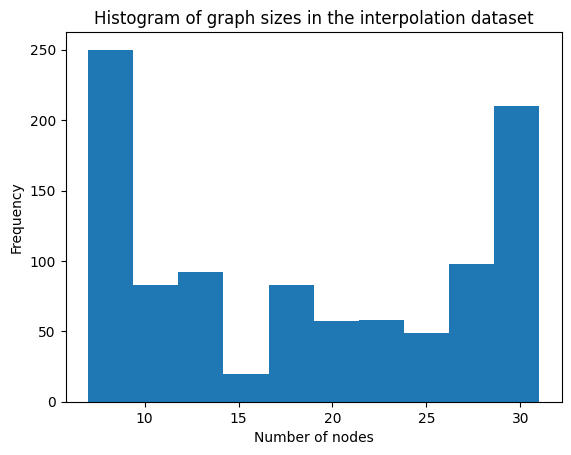

In [36]:
sizes = np.array([int(mask.sum()) for mask in dataset['node_mask'][:]])
import matplotlib.pyplot as plt 
plt.hist(sizes)
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.title('Histogram of graph sizes in the interpolation dataset')
plt.show()

demo for a dataset and loader

In [16]:
class InterpolationDataset(torch.utils.data.Dataset):
    def __init__(self, path_h5, split):
        self.path_h5 = path_h5
        self.split = split
        with h5py.File(self.path_h5, 'r') as f:
            self.X = f[self.split]['X'][:]
            self.A = f[self.split]['A'][:]
            self.node_mask = f[self.split]['node_mask'][:]
            self.alpha = f[self.split]['alpha'][:]
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx]
        a = self.A[idx]
        node_mask = self.node_mask[idx]
        alpha = self.alpha[idx]
        return {
            'x': torch.tensor(x, dtype=torch.float32),
            'a': torch.tensor(a, dtype=torch.float32),
            'node_mask': torch.tensor(node_mask, dtype=torch.bool),
            'alpha': torch.tensor(alpha, dtype=torch.float32)
        }
        
for split in ['train','valid','test']:
    dataset = InterpolationDataset(path_h5, split)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    for batch in loader:
        x = batch['x']
        a = batch['a']
        node_mask = batch['node_mask']
        alpha = batch['alpha']
        print(f'Split: {split}, x shape: {x.shape}, a shape: {a.shape}, node_mask shape: {node_mask.shape}, alpha shape: {alpha.shape}')
        break

Split: train, x shape: torch.Size([32, 12, 4]), a shape: torch.Size([32, 12, 12]), node_mask shape: torch.Size([32, 12]), alpha shape: torch.Size([32])
Split: valid, x shape: torch.Size([32, 12, 4]), a shape: torch.Size([32, 12, 12]), node_mask shape: torch.Size([32, 12]), alpha shape: torch.Size([32])
Split: test, x shape: torch.Size([32, 12, 4]), a shape: torch.Size([32, 12, 12]), node_mask shape: torch.Size([32, 12]), alpha shape: torch.Size([32])
